## Import • Setting

In [2]:
# Complete 
# ! pip install scipy
# ! pip install numpy
# ! pip install matplotlib

In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [6]:
data = sio.loadmat('./sentimentdataset.mat', chars_as_strings=1, matlab_compatible=1)  

bagofword = data['bagofword'] # input value 
sentiment = data['sentiment'] # target value 
sentiment = sentiment.astype(int)
words = data['word']

# join character to word
# ex.) [['h', 'o', 'l', 'e', 's']]  -> "holes"
word = []
for n in range(20):
    word = word + [str(''.join(letter)) for letter in words[n][0]]
print(word)

['holes', 'must', 'top_secret', 'he', 'center', 'other_civilans', 'the_pacific', 'the_navy', 'a_lot', 'surface_must', 'this_book', 'man_named', '<num>_feet', 'would_strongly', 'put_down', 'norman_johnson', 'lawes', 'a_top', 'the_support', 'ten']


In [ ]:
print(bagofword.shape) # (198, 29717)
print(sentiment.shape) # (198, 1)

(198, 29717)
(198, 1)


### Info

In [85]:
numDoc = len(bagofword) # number of documents
numTesting = 50 # number of testing documents
numVoca = len(words) # number of vocabs, use small number (ex. 1000) for debugging
step = (numDoc-numTesting)//10 # number of steps of increment of training documents
repeat = 5 # number of repetitions of the experiment, use small number (ex. 2) for debugging
alpha = 1. # Beta distribution parameter, initially set as 1, i.e., no prior assumption
beta = 1. # Beta distribution parameter, initially set as 1, i.e., no prior assumption
delta = 1e-12 # small amount for preventing log 0

In [21]:
def shuffle_dataset(X, Y, numDoc=None):
    numDoc = numDoc if numDoc is not None else len(Y)
    sample_indices = np.random.permutation(np.arange(numDoc)) # 데이터 인덱스 섞기 ; shape : (198,)

    X = X[sample_indices]
    Y = Y[sample_indices]

    return X,Y

In [ ]:
# 초기화
trainingAccuracy = np.zeros((repeat, step))
testingAccuracy = np.zeros((repeat, step))
avgTraining = np.zeros((step, 1))
stdTraining = np.zeros((step, 1))
avgTesting = np.zeros((step, 1))
stdTesting = np.zeros((step, 1))

for M in range(1, step + 1):
    N = M * 10  # 학습 문서 개수
    
    for rep in range(repeat):
        # 초기화
        cntY = np.zeros((2, 1))  # Y 빈도표
        cntXbyY = np.zeros((numVoca, 2))  # X, Y 빈도표
        probsY = np.zeros((2, 1))  # P(Y)
        probsXbyY = np.zeros((numVoca, 2))  # P(X|Y)
        logProbsSentiment = np.zeros((numDoc, 2))  # logP(Y|X)
        estSentiment = np.zeros((numDoc, 1))  # 예측 결과
        
        # 데이터 섞기 • 나누기 
        X, Y = shuffle_dataset(X=bagofword, Y=sentiment)
        trainX, trainY = X[:N], Y[:N]
        
        # 데이터의 일부로 표 채우기 
        # -------------------------
        # 빈도표 Y 채우기
        cntY[0] = np.sum(trainY.ravel() == 0)
        cntY[1] = np.sum(trainY.ravel() == 1)
        
        # 빈도표 (X, Y) 채우기
        for idx in range(numVoca):
            cntXbyY[idx, 0] = np.sum((trainX[:, idx] == 1) & (trainY.ravel() == 0))
            cntXbyY[idx, 1] = np.sum((trainX[:, idx] == 1) & (trainY.ravel() == 1))
        
        # P(Y) 계산
        probsY[0] = cntY[0] / np.sum(cntY)
        probsY[1] = cntY[1] / np.sum(cntY)
        
        # P(X|Y) 계산 
        for idx in range(numVoca):
            probsXbyY[idx, 0] = (cntXbyY[idx, 0] + alpha - 1) / (cntY[0] + alpha + beta - 2)
            probsXbyY[idx, 1] = (cntXbyY[idx, 1] + alpha - 1) / (cntY[1] + alpha + beta - 2)
        
        # 전체 데이터 분석 시작 
        # -------------------------
        # logP(Y|X) 계산
        for idx in range(numDoc):
            voca_indice_vector = X[idx].astype(bool)
            logProbsSentiment[idx, 0] = np.sum(np.log(probsXbyY[voca_indice_vector, 0] + delta)) + np.log(probsY[0] + delta)
            logProbsSentiment[idx, 1] = np.sum(np.log(probsXbyY[voca_indice_vector, 1] + delta)) + np.log(probsY[1] + delta)
        
        # 예측값 저장
        estSentiment[:, 0] = np.argmax(logProbsSentiment, axis=1)
        
        # 학습 정확도 계산
        correctTrainN = np.sum(Y[:N].ravel() == estSentiment[:N].ravel())
        print(correctTrainN, N)
        trainingAccuracy[rep, M - 1] = correctTrainN / float(N)
        
        # 테스트 정확도 계산
        correctTestN = np.sum(Y[-numTesting:].ravel() == estSentiment[-numTesting:].ravel())
        print(correctTestN, numTesting)
        testingAccuracy[rep, M - 1] = correctTestN / float(numTesting)

        print("Predicted sentiment distribution:", np.bincount(estSentiment.astype(int).ravel()))
        print("Actual sentiment distribution:", np.bincount(Y.ravel()))
        print(" ")
    # 결과 정리
    avgTraining[M - 1] = np.mean(trainingAccuracy[:, M - 1])
    avgTesting[M - 1] = np.mean(testingAccuracy[:, M - 1])
    stdTraining[M - 1] = np.std(trainingAccuracy[:, M - 1])
    stdTesting[M - 1] = np.std(testingAccuracy[:, M - 1])

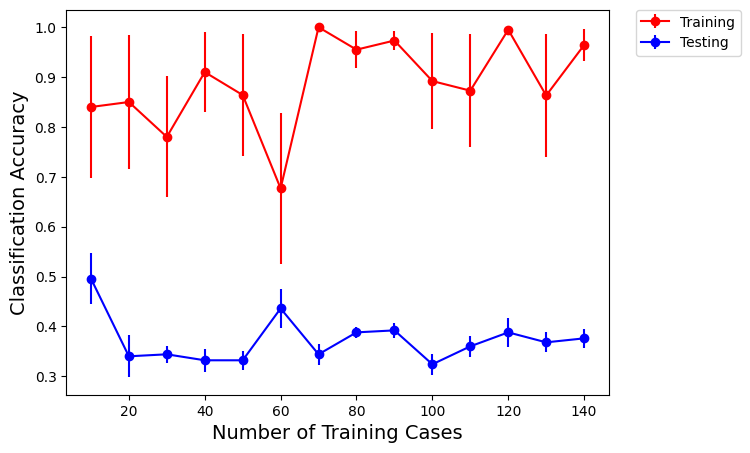

In [84]:
plt.figure(1,figsize=(7,5))
plt.errorbar(np.dot(10,range(1,step+1)),avgTraining.squeeze(),yerr=stdTraining.squeeze()/np.sqrt(repeat),fmt='-o',color='r',label="Training")
plt.errorbar(np.dot(10,range(1,step+1)),avgTesting.squeeze(),yerr=stdTesting.squeeze()/np.sqrt(repeat), fmt='-o',color='b',label="Testing")

plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.xlabel('Number of Training Cases',fontsize=14)
plt.ylabel('Classification Accuracy',fontsize=14)

plt.show()

- Beta(2,2)

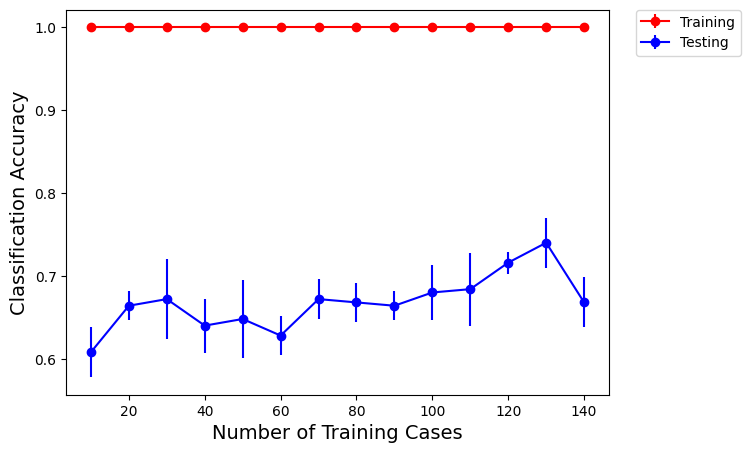

In [87]:
plt.figure(1,figsize=(7,5))
plt.errorbar(np.dot(10,range(1,step+1)),avgTraining.squeeze(),yerr=stdTraining.squeeze()/np.sqrt(repeat),fmt='-o',color='r',label="Training")
plt.errorbar(np.dot(10,range(1,step+1)),avgTesting.squeeze(),yerr=stdTesting.squeeze()/np.sqrt(repeat), fmt='-o',color='b',label="Testing")

plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
plt.xlabel('Number of Training Cases',fontsize=14)
plt.ylabel('Classification Accuracy',fontsize=14)

plt.show()

- Beta(1,1)

데이터가 증가할수록 정답률이 높아진다. 